In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import numpy as np
import os, glob
import time
import warnings
from importlib import reload

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel
import argparse, subprocess


mode1 = 'nh'
fout1 = 1026
repo1,rurmode1,dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, fout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

mode2 = 'nh2'
fout2 = 797
repo2,rurmode2,dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, fout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

def check_order(arr):
    assert arr[0] == 1    
    assert arr[-1] == len(arr)
    assert len(arr)==len(np.unique(arr))


[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


# Preparate Results

In [2]:
dtype1 = [
    ('id', '<i4'), ('timestep', '<i4'), ('nparts', '<i4'), 
    ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('aexp', '<f8'),
    ('x', '<f8'), ('y', '<f8'), ('z', '<f8'),
    ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'),
    ('m', '<f8'), ('r', '<f8')]
dtype2 = [
    ('id', '<i4'), ('nparts', '<i4'), 
    ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), 
    ('x', '<f8'), ('y', '<f8'), ('z', '<f8'),
    ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'),
    ('mvir', '<f8'), ('rvir', '<f8')]
dtype3 = [ ('fcontam', '<f8'), ('dist', '<f8'), ('central', bool), ('main', bool) ]
hdtype2 = np.dtype(dtype2)
hdtype2 = [(f"halo_{iname}", iformat) for iname, iformat in hdtype2.descr ]
dtype = dtype1 + hdtype2 + dtype3


result1_a = np.zeros(len(gal1s), dtype=dtype)
result1_a.dtype
for iname in result1_a.dtype.names:
    if(iname in gal1s.dtype.names):
        result1_a[iname] = gal1s[iname]
print(result1_a[0])
print(result1_a[0].dtype)

result2_a = np.zeros(len(gal2s), dtype=dtype)
result2_a.dtype
for iname in result2_a.dtype.names:
    if(iname in gal2s.dtype.names):
        result2_a[iname] = gal2s[iname]
print(result2_a[0])
print(result2_a[0].dtype)

(1, 1026, 6459716, 1, 1, 0, 0.85361391, 0.46676515, 0.47558907, 0.51981606, 38.10322621, 59.92555592, 42.18115311, 5.70733728e+10, 0.00059946, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., False, False)
[('id', '<i4'), ('timestep', '<i4'), ('nparts', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('aexp', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('m', '<f8'), ('r', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?')]
(1, 797, 13096279, 1, 1, 0, 0.85355043, 0.50144633, 0.499344, 0.50662341, -29.00205929, 90.43488546, -26.06798933, 2.37794424e+11, 0.00202302, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., Fa

# Exclude halos without galaxy

In [3]:
def make_banlist(gals, hals):
    ban = np.zeros(len(hals), dtype=bool)
    for i,hal in tqdm(enumerate(hals), total=len(hals)):
        dists = distance(gals, hal)
        if(np.any(dists  <  gals['r']+hal['r'])):
            pass
        else:
            ban[i] = True
    return ban
ban1 = make_banlist(gal1s, hal1s); print(np.sum(ban1))
ban2 = make_banlist(gal2s, hal2s); print(np.sum(ban2))

  0%|          | 0/29333 [00:00<?, ?it/s]

100%|██████████| 29333/29333 [00:04<00:00, 6568.92it/s]


27358


100%|██████████| 29716/29716 [00:03<00:00, 9630.57it/s]

27868


# Lvl1 halo - Central galaxy pair

In [4]:
def cutting(hal, gals, hban=[],gban=[], lvlmin=0, lvlmax=1):
    if(hal['id'] in hban): return 0, 0
    if( (hal['level']<lvlmin) or (hal['level']>lvlmax) ): return 0, 0

    # Initial cut
    if(len(gban)>0):
        mems = gals[np.isin(gals['id'], gban, invert=True, assume_unique=True)]
    else:
        mems = gals
    if(len(mems)==0): return 0,0

    dists = distance(mems, hal)
    mems = mems[dists < (mems['r']+hal['rvir'])]
    if(len(mems)==0): return 0,0
    if(len(mems)==1): return mems[0]['id'],1

    # Cut by rvir
    temp = cut_sphere(mems, hal['x'], hal['y'], hal['z'], hal['rvir'])
    mems = temp if(len(temp)>0) else mems
    if(len(mems)==1): return mems[0]['id'],2

    # Cut by lvl
    lvlcut = 0
    temp = mems[mems['level']<=lvlcut]
    while(len(temp)==0):
        lvlcut += 1
        temp = mems[mems['level']<=lvlcut]
    if(len(mems)==1): return mems[0]['id'],3

    # Cut by halo center
    dists = distance(mems, hal)
    temp = mems[dists < mems['r']]
    mems = temp if(len(temp)>0) else mems
    if(len(mems)==1): return mems[0]['id'],4

    # Cut by mass
    return mems[np.argmax(mems['m'])]['id'],5

In [5]:
def find_cengal_of_lvl1hals(gals, hals, bans):
    gal_of_hals = np.zeros(len(hals), dtype=int)
    scores = np.zeros(len(hals), dtype=int)
    hban = np.where(bans)[0]+1
    for i, hal in tqdm(enumerate(hals), total=len(hals)):
        debug=False
        if(bans[i]): continue
        if(hal['level'] != 1): continue
        gid, score = cutting(hal, gals, hban=hban, lvlmin=1, lvlmax=1)
        # if(gid==490): debug=True
        if(gid>0):
            if(debug): print(f"Found a galaxy {gid} for halo {hal['id']}")
            if(gid in gal_of_hals):
                where = np.where(gal_of_hals==gid)[0][0]
                if(debug): print(f"Found a galaxy {gid} for another halo {where+1}")
                # Competition
                if(score > scores[where]):
                    if(debug): print(f"{score} > {scores[where]}, so change")
                    gal_of_hals[where] = -gid
                    scores[where] = -gid
                    gal_of_hals[i] = gid
                    scores[i] = score
                elif(score < scores[where]):
                    if(debug): print(f"{score} < {scores[where]}, so pass")
                    pass
                else:
                    if(debug): print(f"{score} = {scores[where]}, so check distance")
                    check_order(gals['id'])
                    gal = gals[gid-1]
                    my_dist = distance(gal, hal)
                    other_dist = distance(gal, hals[where])
                    if(my_dist < other_dist):
                        if(debug): print(f"{my_dist} < {other_dist}, so change")
                        gal_of_hals[where] = -gid
                        scores[where] = -gid
                        gal_of_hals[i] = gid
                        scores[i] = score
                    else:
                        if(debug): print(f"{my_dist} > {other_dist}, so pass")
                        pass
            else:
                if(debug): print(f"Found a galaxy {gid} for the first time")
                gal_of_hals[i] = gid
                scores[i] = score


    return gal_of_hals, scores

result1_b = np.copy(result1_a)
gid1s, score1s = find_cengal_of_lvl1hals(gal1s, hal1s, ban1)
check_dupl(gid1s[gid1s>0])
names = result1_b.dtype.names
names = [name for name in names if(name[:4]=='halo')]
for i, gid1 in enumerate(gid1s):
    if(gid1>0):
        ihal = hal1s[i]
        check_order(result1_b['id'])
        result1_b[gid1-1]['central'] = True
        result1_b[gid1-1]['main'] = True
        for iname in names:
            result1_b[gid1-1][iname] = ihal[iname[5:]]

result2_b = np.copy(result2_a)
gid2s, score2s = find_cengal_of_lvl1hals(gal2s, hal2s, ban2)
check_dupl(gid2s[gid2s>0])
names = result2_b.dtype.names
names = [name for name in names if(name[:4]=='halo')]
for i, gid2 in enumerate(gid2s):
    if(gid2>0):
        ihal = hal2s[i]
        check_order(result2_b['id'])
        result2_b[gid2-1]['central'] = True
        result2_b[gid2-1]['main'] = True
        for iname in names:
            result2_b[gid2-1][iname] = ihal[iname[5:]]

  0%|          | 0/29333 [00:00<?, ?it/s]

100%|██████████| 29716/29716 [00:00<00:00, 150369.28it/s]


In [6]:
result1_b[876-1]['halo_id']

0

# Central galaxy of other halos

In [7]:
def find_cengal_of_others(hals, gals, bans, result):
    gal_of_hals = np.zeros(len(hals), dtype=int)
    scores = np.zeros(len(hals), dtype=int)

    already = result[result['halo_id'] > 0]
    hban = already['halo_id']
    gban = already['id']
    for i, hal in tqdm(enumerate(hals), total=len(hals)):
        if(bans[i]): continue
        if(hal['id'] in already['halo_id']): continue
        gid, score = cutting(hal, gals, hban=hban, gban=gban, lvlmin=0, lvlmax=10)
        if(gid>0):
            if(gid in gal_of_hals):
                where = np.where(gal_of_hals==gid)[0][0]
                # Competition
                if(score > scores[where]):
                    gal_of_hals[where] = -gid
                    scores[where] = -gid
                    gal_of_hals[i] = gid
                    scores[i] = score
                elif(score < scores[where]):
                    pass
                else:
                    check_order(gals['id'])
                    gal = gals[gid-1]
                    my_dist = distance(gal, hal)
                    other_dist = distance(gal, hals[where])
                    if(my_dist < other_dist):
                        gal_of_hals[where] = -gid
                        scores[where] = -gid
                        gal_of_hals[i] = gid
                        scores[i] = score
                    else:
                        pass
            else:
                gal_of_hals[i] = gid
                scores[i] = score


    return gal_of_hals, scores

result1_c = np.copy(result1_b)
check_order(result1_c['id'])
gid1s, score1s = find_cengal_of_others(hal1s, gal1s, ban1, result1_b)
check_dupl(gid1s[gid1s>0])
names = result1_b.dtype.names
names = [name for name in names if(name[:4]=='halo')]
count =0
for i, gid1 in enumerate(gid1s):
    if(gid1>0):
        count += 1
        if(result1_c[gid1-1]['halo_id']<=0):
            ihal = hal1s[i]
            result1_c[gid1-1]['central'] = True
            result1_c[gid1-1]['main'] = hal1s[i]['level']==1
            for iname in names:
                result1_c[gid1-1][iname] = ihal[iname[5:]]
print(count)

result2_c = np.copy(result2_b)
check_order(result2_c['id'])
gid2s, score2s = find_cengal_of_others(hal2s, gal2s, ban2, result2_b)
check_dupl(gid2s[gid2s>0])
names = result2_b.dtype.names
names = [name for name in names if(name[:4]=='halo')]
count =0
for i, gid2 in enumerate(gid2s):
    if(gid2>0):
        count += 1
        if(result2_c[gid2-1]['halo_id']<=0):
            ihal = hal2s[i]
            result2_c[gid2-1]['central'] = True
            result2_c[gid2-1]['main'] = hal2s[i]['level']==1
            for iname in names:
                result2_c[gid2-1][iname] = ihal[iname[5:]]
print(count)


  0%|          | 0/29333 [00:00<?, ?it/s]

100%|██████████| 29333/29333 [00:01<00:00, 17611.91it/s] 


558


100%|██████████| 29716/29716 [00:00<00:00, 38499.10it/s] 

408


In [8]:
result1_c[876-1]['halo_id']

0

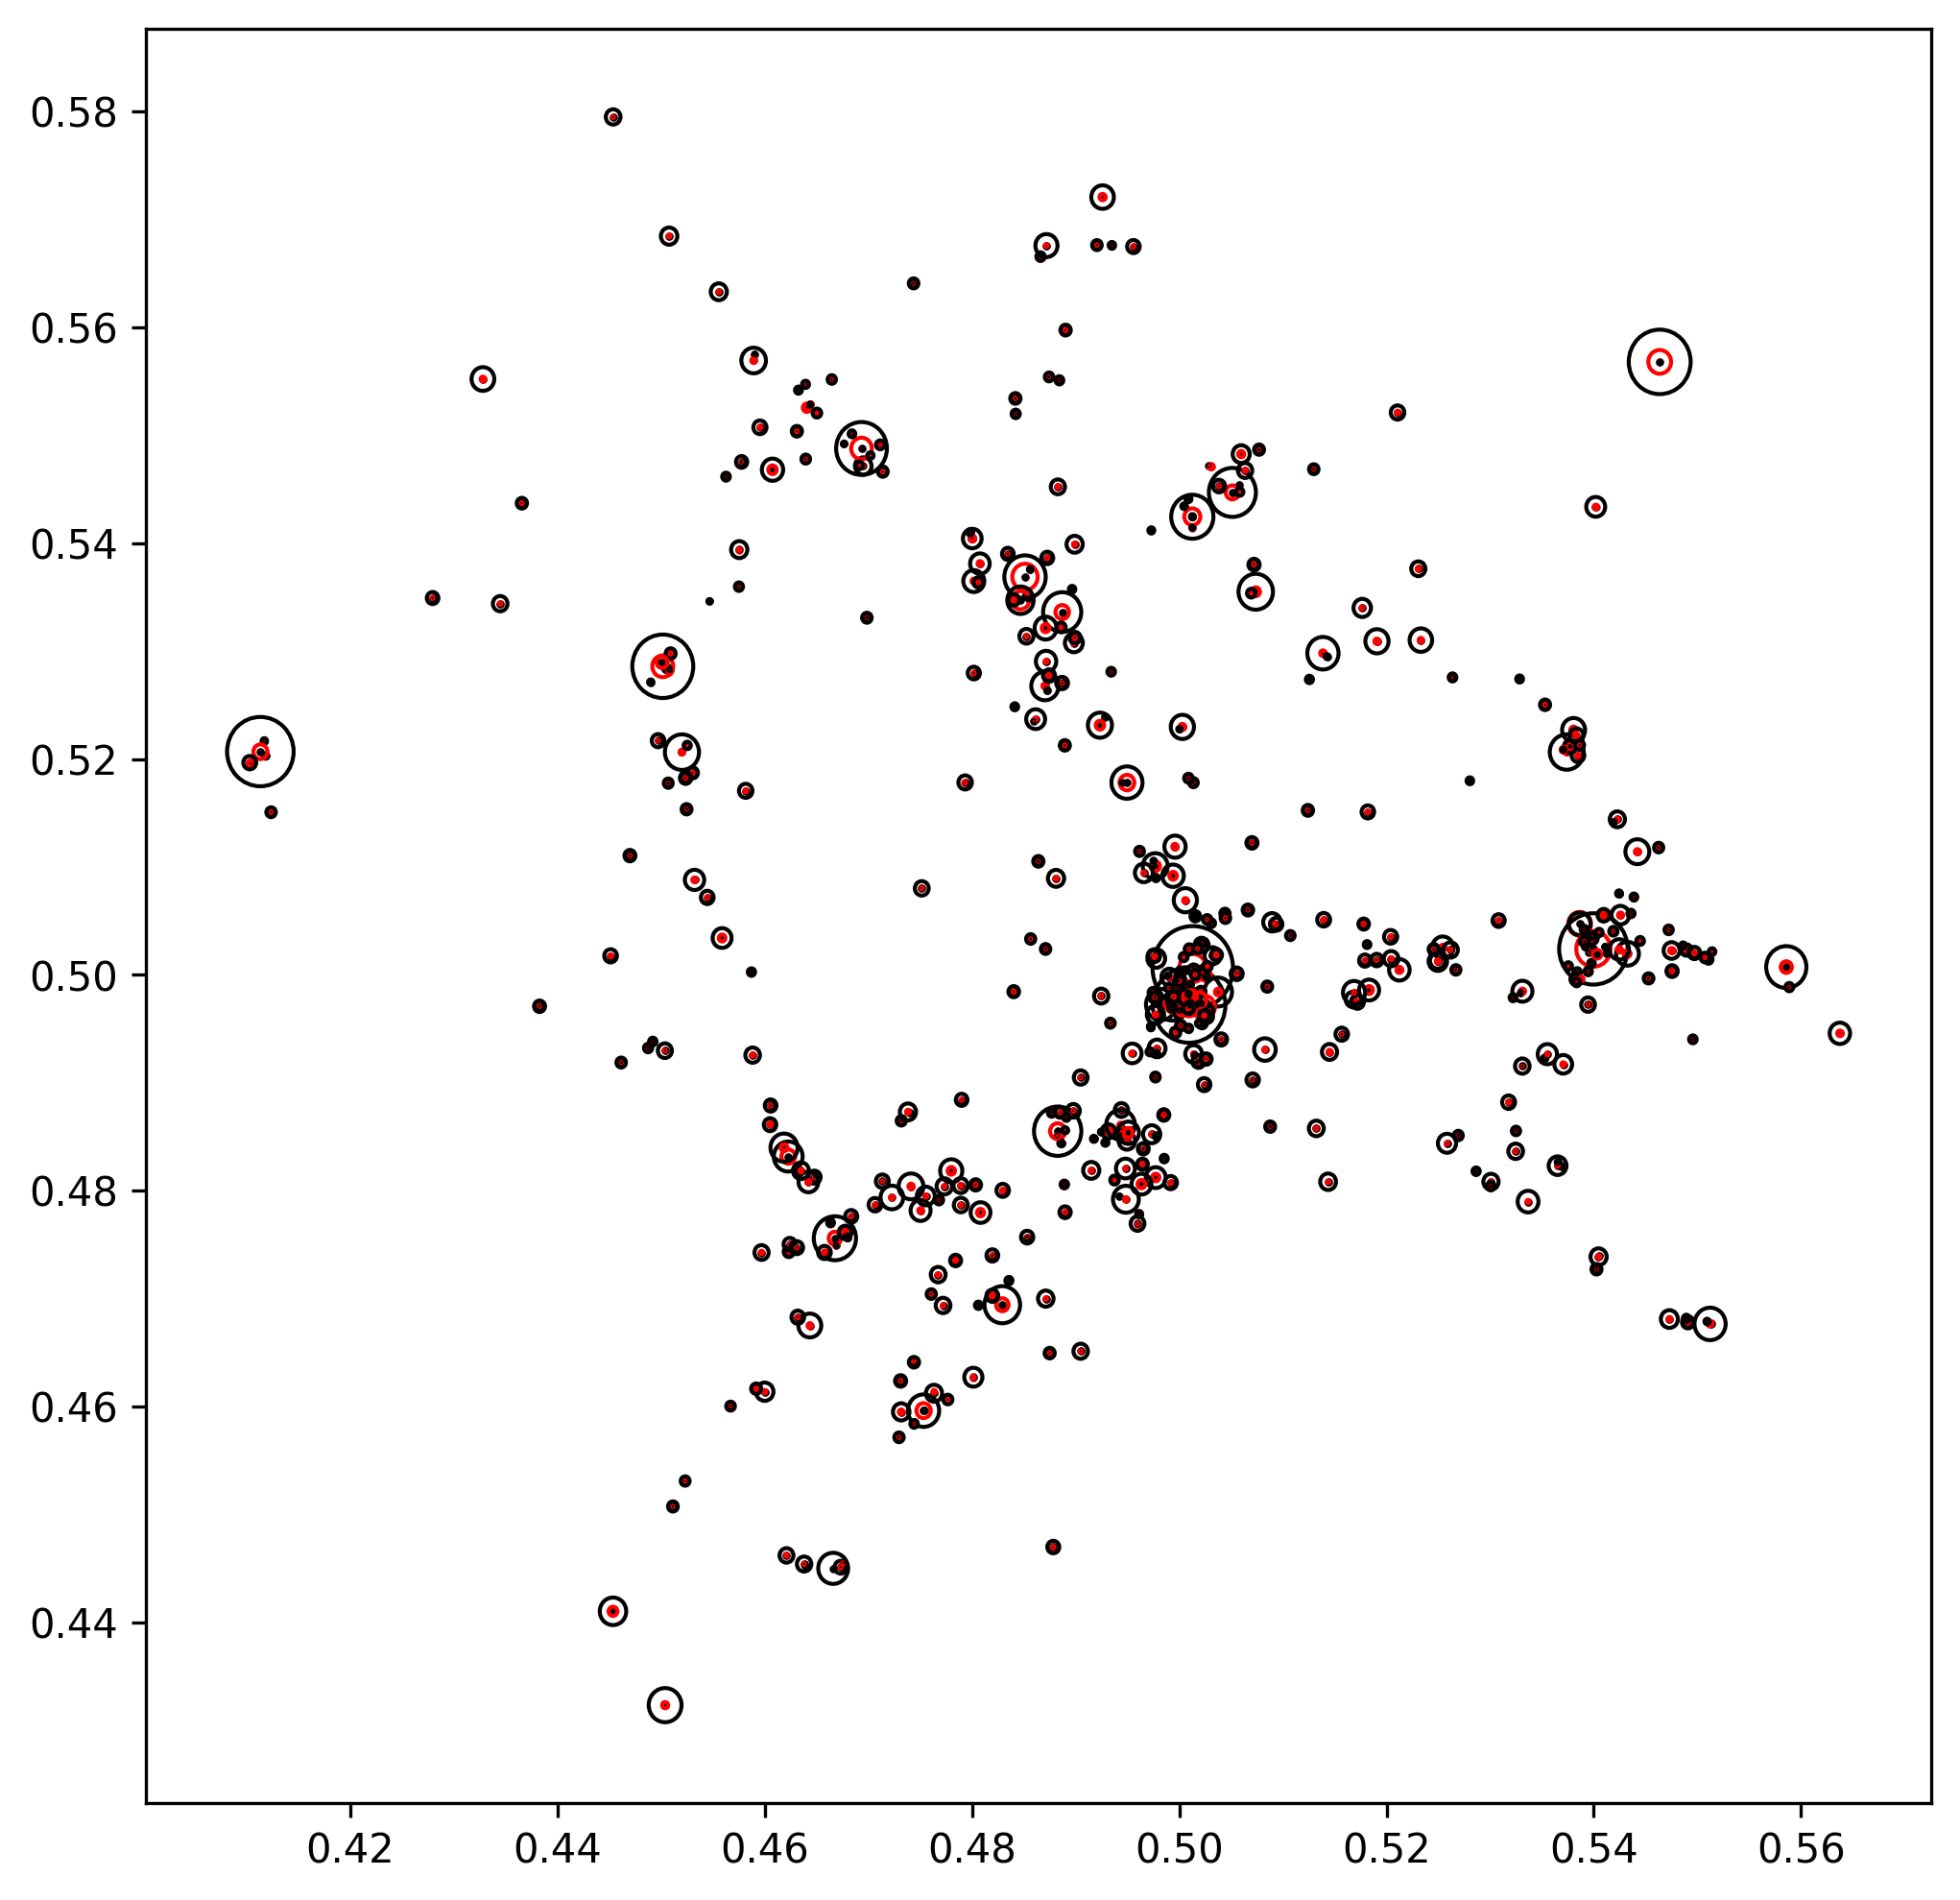

In [9]:
temp = result1_c[result1_c['halo_id'] > 0][:500]
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax.scatter(temp['x'], temp['y'], s=1, color='r')
ax.scatter(temp['halo_x'], temp['halo_y'], s=1, color='k')
for it in temp:
    cir = plt.Circle((it['x'], it['y']), it['r'], color='r', fill=False)
    ax.add_patch(cir)
    cir = plt.Circle((it['halo_x'], it['halo_y']), it['halo_rvir'], color='k', fill=False)
    ax.add_patch(cir)


# Remaining Galaxies

In [10]:
print("NH")
arr = result1_c
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

print("\nNH2")
arr = result2_c
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

NH
1073 has host halos (of 4070)

NH2
871 has host halos (of 1528)


In [11]:
def find_halos_for_other(gal, hals, results, debug=False):
    check_order(hals['id'])
    check_order(results['id'])
    if(debug): print("\n Here reports:")
    # return halo_id, central, main
    dist, hid, central, main = 1, 0, False, False
    host = None
    hosts = None
    key = 'hostsub' if(gal['hostsub']>0) else 'host'
    if(debug): print(f" > key={key}")
    if(gal['level']>1):
        host = results[gal[key]-1]
        while(host['halo_id']<=0):
            host = results[host[key]-1]
            if(host['level']==1):
                break
        if(debug): print(f" > For this lvl.{gal['level']} galaxy, host={host['id']}")
    else:
        dists = distance(results, gal)
        hosts = results[dists < results['r']]
        hosts = hosts[hosts['id'] != gal['id']]
        if(debug): print(f" > For this lvl.{gal['level']} galaxy, hosts={hosts['id']}")
        if(len(hosts)>0):
            dists = distance(hosts, gal)
            host = hosts[np.argmin(dists)]
            while(host['halo_id']<=0):
                
                host = results[host[key]-1]
                if(host['level']==1):
                    break
            if(debug): print(f" > \thost={host['id']}")
    
    thalos = cut_sphere(hals, gal['x'], gal['y'], gal['z'], gal['r'])
    if(debug): print(" > cutsph: ",thalos['id'])
    hids = thalos['id']
    if(host is not None):
        hids = np.append(hids, host['halo_id'])
    if(hosts is not None):
        hids = np.append(hids, hosts['halo_id'])
    hids = hids[hids>0]
    hids = np.unique(hids)
    thalos = hals[hids-1]
    if(debug): print(" > concat: ",thalos['id'])
    if(len(thalos)==0): return dist, hid, central, main

    gals_of_hals = [[]] * len(thalos)
    for i, thalo in enumerate(thalos):
        if(thalo['id'] in results['halo_id']):
            gals_of_hals[i] = np.where(results['halo_id']==thalo['id'])[0]
    lengs = np.array([len(iarr) for iarr in gals_of_hals])
    wheres = np.where(lengs==0)[0]
    if(len(wheres)==0):
        # All halos have galaxies
        if(host is not None):
            
            hid = host['halo_id']
            
            thalo = hals[hid-1]
            dist = distance(thalo, gal)
            central = False
            main = host['main']
        else:
            if(debug): print("fail!")
            pass
    elif(len(wheres)==1):
        # Only one halo has no galaxy
        thalo = thalos[wheres[0]]
        dist = distance(thalo, gal)
        hid = thalo['id']
        central = True
        main = (thalo['level']==1)
    else:
        # Multiple halos have no galaxy
        if(host is not None):
            hid = host['halo_id']
            if(debug): print("hid of host: ",hid)
            thalo = hals[hid-1]
            dist = distance(thalo, gal)
            central = False
            main = host['main']
        else:
            dists = distance(thalos, gal)
            thalo = thalos[np.argmin(dists)]
            dist = dists[np.argmin(dists)]
            hid = thalo['id']
            central = True
            main = (thalo['level']==1)
    if(debug): print(host)
    return dist, hid, central, main




def find_halos_for_others(hals, results, debug=False):
    argsort = np.lexsort((results['id'], -results['m'], results['level']))
    gals = results[argsort]
    arr = np.empty(len(gals), dtype=[('id','i4'),('m','f8'),('level','i4'),('dist','f8'), ('halo_id', 'i4'), ('central', 'bool'), ('main', 'bool')])
    arr['id'] = -1
    for ith in tqdm(range(len(gals))):
        gal = gals[ith]
        if(gal['halo_id']>0): continue
        dist, hid, central, main = find_halos_for_other(gal, hals, results, debug=False)#gal['id']==1024 )
        arr[ith]['id'] = gal['id']
        arr[ith]['m'] = gal['m']
        arr[ith]['level'] = gal['level']
        arr[ith]['dist'] = dist
        arr[ith]['halo_id'] = hid
        arr[ith]['central'] = central
        arr[ith]['main'] = main
    return arr[(arr['id']>0)&(arr['halo_id']>0)]

def find_halos_for_otherss(hals, results):
    arr = find_halos_for_others(hals, results, debug=False)
    gals = np.copy(results)
    check_order(gals['id'])

    unique, count = np.unique(arr['halo_id'], return_counts=True)
    for uni, cou in tqdm(zip(unique, count), total=len(unique)):
        insts = arr[arr['halo_id'] == uni]
        if(uni in gals['halo_id']):
            # Already central in `gals`
            for inst in insts:
                gals[inst['id']-1]['halo_id'] = uni
                gals[inst['id']-1]['central'] = inst['central']
                gals[inst['id']-1]['main'] = inst['main']
        else:
            # Not central in `gals`
            insts = arr[arr['halo_id'] == uni]
            if(np.sum(insts['central'])>1):
                # Multiple centrals
                # fig, ax = plt.subplots()
                # print(f"{insts['id']}\nasserts they are centrals of {uni}!!!")
                # for inst in insts:
                #     igal = gals[inst['id']-1]
                #     print("\t", igal['id'], igal['host'], igal['hostsub'], inst['halo_id'])
                #     ax.scatter(igal['x'], igal['y'], s=igal['r']*10, alpha=0.5)
                #     cir = plt.Circle((igal['x'], igal['y']), igal['r'], color='r', fill=False)
                #     ax.add_patch(cir)
                # check_order(hals['id'])
                # ihal = hals[uni-1]
                # print(ihal['id'], ihal['id'] in gals['halo_id'])
                # cir = plt.Circle((ihal['x'], ihal['y']), ihal['r'], color='b', fill=False)
                # ax.add_patch(cir)

                # others = cut_sphere(gals, ihal['x'], ihal['y'], ihal['z'], ihal['r'])
                # for other in others:
                #     if(other['id'] in insts['id']): continue
                #     ax.text(other['x'], other['y']+other['r'], str(other['id']), ha='center', va='bottom')
                #     print(other['id'], other['halo_id'])
                #     cir = plt.Circle((other['x'], other['y']), other['r'], color='g', fill=False)
                #     ax.add_patch(cir)

                # ax.set_aspect('equal')
                # plt.show()
                # stop()

                pass
            elif(np.sum(insts['central'])==0):
                # No centrals
                pass
            else:
                # One central
                inst = insts[0]
                gals[inst['id']-1]['halo_id'] = uni
                gals[inst['id']-1]['central'] = inst['central']
                gals[inst['id']-1]['main'] = inst['main']
    return gals
result1_d = find_halos_for_otherss(hal1s, result1_c)
result2_d = find_halos_for_otherss(hal2s, result2_c)

 20%|██        | 818/4070 [00:00<00:00, 8068.21it/s]

100%|██████████| 163/163 [00:00<00:00, 8852.18it/s]


In [12]:
print("NH")
arr = result1_d
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

print("\nNH2")
arr = result2_d
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

NH
3993 has host halos (of 4070)

NH2
1516 has host halos (of 1528)


# Really remaining

In [13]:
def final_job(hals, results):
    gals = np.copy(results)
    for gal in gals:
        if(gal['halo_id']>0): continue
        neighbors = cut_sphere(results, gal['x'], gal['y'], gal['z'], gal['r'], both_sphere=True, rname='r')
        if(len(neighbors)>0):
            dists = distance(neighbors, gal)
            ineigh = neighbors[ np.argmin(dists) ]
            halo_id = ineigh['halo_id']
            if(halo_id>0):
                gal['halo_id'] = halo_id
                gal['central'] = False
                gal['main'] = ineigh['main']
                continue
        ihals = cut_sphere(gals, gal['x'], gal['y'], gal['z'], gal['r'], both_sphere=True, rname='r')
        if(len(ihals)>0):
            dists = distance(ihals, gal)
            ihal = ihals[ np.argmin(dists) ]
            gal['halo_id'] = ihal['id']
            gal['central'] = False if(ihal['id'] in results['halo_id']) else True
            gal['main'] = True if(ihal['host'] == ihal['id']) else False
    names = gals.dtype.names
    names = [iname for iname in names if(iname[:5] == 'halo_')]
    for gal in gals:
        hal = hals[gal['halo_id']-1]
        gal['dist'] = distance(hal, gal)
        gal['fcontam'] = hal['mcontam']/hal['m']
        if(gal['halo_mvir']>0): continue
        for iname in names:
            gal[iname] = hal[iname[5:]]
    return gals
result1_e = final_job(hal1s, result1_d)
result2_e = final_job(hal2s, result2_d)

print("NH")
arr = result1_e
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

print("\nNH2")
arr = result2_e
print(f"{np.sum(arr['halo_id']>0)} has host halos (of {len(arr)})")

NH
4070 has host halos (of 4070)

NH2
1528 has host halos (of 1528)


In [15]:
True in np.isin(result1_e['halo_id'], ban1), True in np.isin(result2_e['halo_id'], ban2)

(False, False)

In [303]:
result1_e.dtype

dtype([('id', '<i4'), ('timestep', '<i4'), ('nparts', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('aexp', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('m', '<f8'), ('r', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?')])

In [304]:
minmax(result1_e['r']), minmax(result1_e['dist'])

len4070: min=7.67882535141619e-08, mean=4.4870739363953636e-05, max=0.0016503960023615636
len4070: min=8.99018141579038e-08, mean=0.0026036877533616243, max=0.5811757837949386


(None, None)

In [305]:
result1_e['halo_mvir']

array([1.17616941e+12, 8.13017735e+12, 4.76106794e+11, ...,
       8.72037127e+10, 8.72037127e+10, 8.72037127e+10])

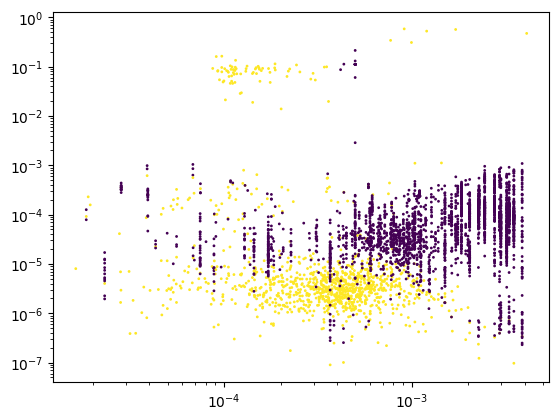

In [306]:
plt.scatter(result1_e['halo_rvir'], result1_e['dist'], s=1, label='1', c=result1_e['central'])
plt.xscale('log')
plt.yscale('log')

66 12.910100019334198 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


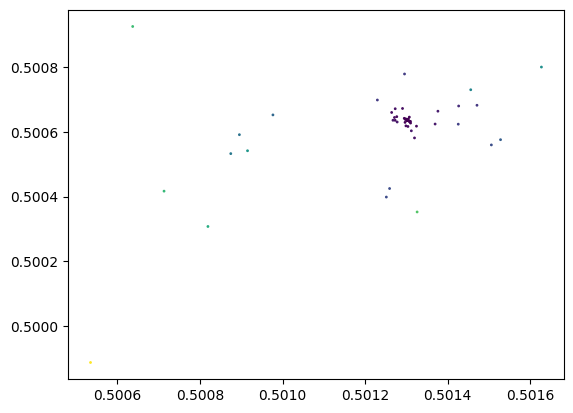

In [311]:
temp = result1_e[result1_e['fcontam'] < 0.1]
mmax = np.max(temp['halo_mvir'])
gals = temp[temp['halo_mvir'] >= mmax*0.999]
print(len(gals), np.log10(mmax), gals['fcontam'])
print(gals['central'])
plt.scatter(gals['x'], gals['y'], s=1, c=gals['dist'])

1094 1094 0


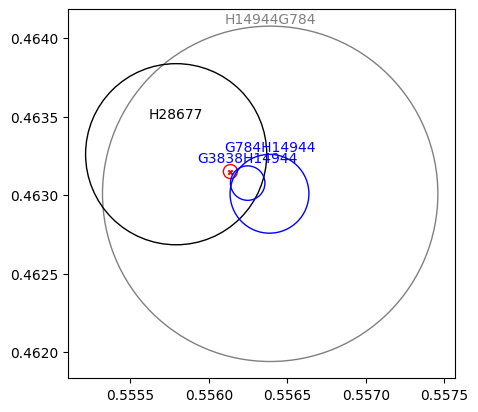

In [257]:
orphans = result1_d[ result1_d['halo_id']==0 ]
orphan = np.random.choice(orphans)
print(orphan['id'], orphan['host'], orphan['hostsub'])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(orphan['x'], orphan['y'], s=10, marker='x', c='r')
cir = plt.Circle((orphan['x'], orphan['y']), orphan['r'], color='r', fill=False)
ax.add_patch(cir)

hals = cut_sphere(hal1s, orphan['x'], orphan['y'], orphan['z'], orphan['r'], both_sphere=True)
for hal in hals:
    if(hal['id'] in result1_d['halo_id']):
        color = 'grey'
        insts = result1_d[ result1_d['halo_id']==hal['id'] ]
        inst = insts[insts['central']]
        if(len(inst)==0): inst = [insts[0]]
        text = f"H{hal['id']}G{inst[0]['id']}"
        rkey = 'rvir'
    else:
        color = 'k'
        text = f"H{hal['id']}"
        rkey = 'r'
    cir = plt.Circle((hal['x'], hal['y']), hal[rkey], color=color, fill=False)
    ax.add_patch(cir)
    ax.text(hal['x'], hal['y']+hal['rvir'], text, color=color, fontsize=10, ha='center', va='bottom')
gals = cut_sphere(result1_d, orphan['x'], orphan['y'], orphan['z'], orphan['r'], both_sphere=True)
for gal in gals:
    if(gal['id'] == orphan['id']): continue
    cir = plt.Circle((gal['x'], gal['y']), gal['r'], color='b', fill=False)
    ax.add_patch(cir)
    ax.text(gal['x'], gal['y']+gal['r'], f"G{gal['id']}H{gal['halo_id']}", color='b', fontsize=10, ha='center', va='bottom')
ax.set_aspect('equal')


In [160]:
result1_c[254-1]['halo_id']

24229

In [153]:
254 in arr['id']

False

In [140]:
unique, count = np.unique(arr['halo_id'], return_counts=True)
for uni, cou in zip(unique, count):
    insts = arr[arr['halo_id'] == uni]
    if(uni in result1_c['halo_id']):
        pass
    else:
        insts = arr[arr['halo_id'] == uni]
        print(uni, cou, np.sum(insts['central']))
    # if(cou > 1):
    #     print(uni, cou)

5608 1 1
5750 11 11
7974 5 5
10849 9 9
10906 18 18
19358 1 1
19738 1 1
19930 1 1
19971 1 1
20114 1 1
20146 1 1
20166 1 1
20175 1 1
20179 1 1
22075 1 1
22230 1 1
22231 1 1
22235 1 1
22237 1 1
22699 3 3
22705 3 3
22714 1 1
23402 8 8
23404 1 1
23471 1 1
23494 1 1
24250 1 1
24285 16 16
24370 1 1
24503 1 1
24504 1 1
24588 18 18
25284 1 1
26700 19 19
26703 1 1
26718 3 3
26838 1 1
26926 1 1
27077 6 6
27184 1 1
27367 1 1
27397 1 1
28295 9 9
28304 6 6
28677 3 3
29333 5 5


In [122]:
argsort = np.lexsort((result1_c['id'], -result1_c['m'], result1_c['level']))
result1_d = result1_c[argsort]
result1_d[['level', 'm', 'id']]

array([(1, 2.38222047e+11,    4), (1, 2.36677560e+11,    2),
       (1, 1.96139600e+11,    9), ..., (4, 1.02251898e+06, 3786),
       (4, 1.00533379e+06, 4060), (4, 9.00989725e+05, 2345)],
      dtype={'names': ['level', 'm', 'id'], 'formats': ['<i4', '<f8', '<i4'], 'offsets': [12, 80, 0], 'itemsize': 190})

In [109]:
minmax(result1_c['halo_id'])

len4070: min=0, mean=4189.734152334152, max=29185


My name is 681 (lvl.1).
You may not believe, but I'm a central galaxy
I'm in 1 halos
 > Halo 474 has galaxy 591
[474]
[474]
fail!


(0, False, False)

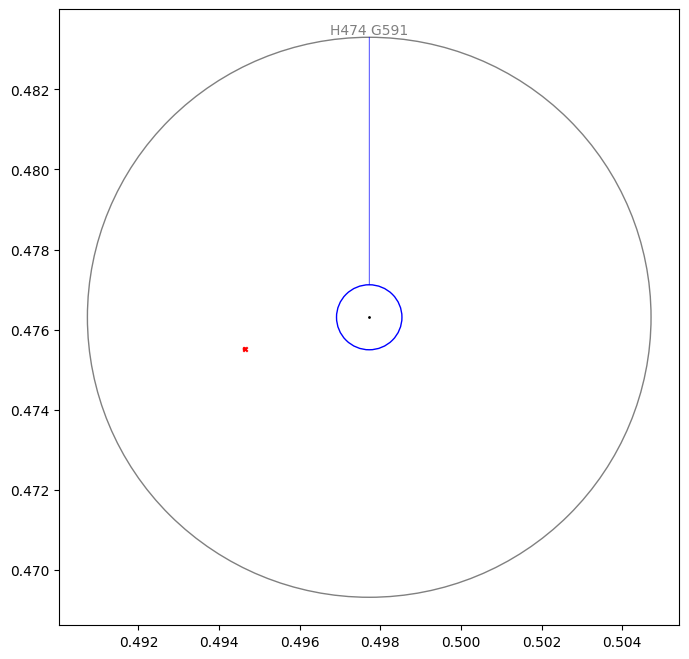

In [119]:
# See one by one

samples = result1_c[result1_c['halo_id'] == 0]
samples = samples[samples['level']==1]
target = np.random.choice(samples)
print(f"My name is {target['id']} (lvl.{target['level']}).")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))


if(target['level']>1):
    host = result1_c[target['hostsub']-1]
    print(f"I have a host galaxy {host['id']}")
    cir = plt.Circle((host['x'], host['y']), host['r'], color='salmon', fill=False)
    ax.add_patch(cir)
else:
    print("You may not believe, but I'm a central galaxy")
    dists = distance(result1_c, target)
    hosts = result1_c[dists < result1_c['r']]
    hosts = hosts[hosts['id'] != target['id']]
    if(len(hosts)>0):
        print(f"However, I'm in the galaxies: [{', '.join([str(igal['id']) for igal in hosts])}]")
        for host in hosts:
            cir = plt.Circle((host['x'], host['y']), host['r'], color='skyblue', fill=False)
            ax.add_patch(cir)


thalos = cut_sphere(hal1s, target['x'], target['y'], target['z'], target['r']*2, both_sphere=True)
if(hosts is not None):
    hosts = hosts[hosts['halo_id']>0]
    temp = hal1s[hosts['halo_id']-1]
    thalos = np.concatenate((thalos, temp[np.isin(temp['id'], thalos['id'], invert=True)]))
print(f"I'm in {len(thalos)} halos")
ax.scatter(thalos['x'], thalos['y'], s=1, color='k')
ax.scatter(target['x'], target['y'], s=10, marker='x', color='r')
for thalo in thalos:
    color='k'
    if(thalo['id'] in result1_c['halo_id']):
        color='grey'
        where = np.where(result1_c['halo_id'] == thalo['id'])[0][0]
        tgal = result1_c[where]
        print(f" > Halo {thalo['id']} has galaxy {tgal['id']}")
        ax.text(thalo['x'], thalo['y']+thalo['r'], f"H{thalo['id']} G{tgal['id']}", fontsize=10, color=color, ha='center', va='bottom')
        cir = plt.Circle((tgal['x'], tgal['y']), tgal['r'], color='b', fill=False)
        ax.add_patch(cir)
        ax.plot([thalo['x'], tgal['x']], [thalo['y']+thalo['r'], tgal['y']+tgal['r']], color='b', lw=0.5)
    else:
        ax.text(thalo['x'], thalo['y']+thalo['r'], f"H{thalo['id']}", fontsize=10, color=color, ha='center', va='bottom')
        print(f" > Halo {thalo['id']} doesn't have galaxy")
    cir = plt.Circle((thalo['x'], thalo['y']), thalo['r'], color=color, fill=False)
    ax.add_patch(cir)
cir = plt.Circle((target['x'], target['y']), target['r'], color='r', fill=False)
ax.add_patch(cir)

find_halos_for_others(target, hal1s, result1_c, debug=False)